In [1]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   363k      0 --:--:-- --:--:-- --:--:--  363k
Cloning into 'simulated-data-transformed'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 189 (delta 0), reused 3 (delta 0), pack-reused 186
Receiving objects: 100% (189/189), 70.08 MiB | 19.77 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (184/184), done.


Carregamento de dados 

In [2]:
DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: user 380 ms, sys: 371 ms, total: 752 ms
Wall time: 771 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [3]:
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

Implementação do Autoencoder

In [4]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

seed_everything(SEED)

Selected device is cuda


In [5]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

In [6]:
class FraudDatasetUnsupervised(torch.utils.data.Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index].to(DEVICE)
        if self.output:
            return item, item
        else:
            return item

In [7]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

In [8]:
training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

In [9]:
class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

In [10]:
criterion = torch.nn.MSELoss().to(DEVICE)

Usando o autoencoder para detecção de fraude não supervisionada 

In [11]:
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses

In [12]:
seed_everything(SEED)
model = SimpleAutoencoder(x_train.shape[1], 100, 20).to(DEVICE)
losses = per_sample_mse(model, valid_generator)

In [13]:
print(losses[0:5])
print(np.mean(losses))

[0.6754841, 0.7914626, 1.1697073, 0.807015, 1.258897]
0.9325166


In [14]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [15]:
model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=500,
                                                                        verbose=True)


Epoch 0: train loss: 0.44572424067337474
valid loss: 0.11789110712503476
New best score: 0.11789110712503476

Epoch 1: train loss: 0.08445227142231072
valid loss: 0.04473799502914721
New best score: 0.04473799502914721

Epoch 2: train loss: 0.0381344713219023
valid loss: 0.028129172457453333
New best score: 0.028129172457453333

Epoch 3: train loss: 0.02394542771250893
valid loss: 0.016839718099052464
New best score: 0.016839718099052464

Epoch 4: train loss: 0.013856801749287212
valid loss: 0.009604579241834377
New best score: 0.009604579241834377

Epoch 5: train loss: 0.007683097759936625
valid loss: 0.005340768681340367
New best score: 0.005340768681340367

Epoch 6: train loss: 0.0052787680009711195
valid loss: 0.004115462845924203
New best score: 0.004115462845924203

Epoch 7: train loss: 0.004053215486225432
valid loss: 0.0031357057164855748
New best score: 0.0031357057164855748

Epoch 8: train loss: 0.0030779106702511316
valid loss: 0.002502947990385602
New best score: 0.0025029

In [16]:
losses = per_sample_mse(model, valid_generator)
print(losses[0:5])
print(np.mean(losses))

[3.356683e-05, 2.8575318e-05, 3.6668633e-05, 4.5275126e-05, 3.6295874e-05]
7.020987e-05


In [17]:
print(x_train[0])
print(model(x_train[0].to(DEVICE)))

tensor([-0.1323, -0.6306,  2.1808, -0.3003,  0.1241, -1.6917,  0.5035, -1.6630,
        -0.0482, -0.9810, -0.0816, -1.9895, -0.1231, -0.9719, -0.1436])
tensor([-0.1361, -0.6269,  2.1802, -0.2969,  0.1199, -1.6987,  0.5019, -1.6770,
        -0.0492, -0.9761, -0.0751, -1.9800, -0.1182, -0.9698, -0.1375],
       device='cuda:0', grad_fn=<AddBackward0>)


In [18]:
genuine_losses = np.array(losses)[y_valid.cpu().numpy() == 0]
fraud_losses = np.array(losses)[y_valid.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.0013619738
Average genuine reconstruction error: 6.189899e-05


In [19]:
predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.84,0.163,0.2


Comparação com outra linha de base não supervisionada: Isolation Forest

In [20]:
from sklearn.ensemble import IsolationForest

anomalyclassifier = IsolationForest(random_state=SEED, n_estimators=10)
anomalyclassifier.fit(train_df[input_features])

IsolationForest(n_estimators=10, random_state=42)

In [21]:
predictions_df = valid_df
predictions_df['predictions'] = -anomalyclassifier.score_samples(valid_df[input_features])
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.808,0.164,0.19


Representação, visualização e agrupamento de transações

In [22]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
small_model = SimpleAutoencoder(len(input_features), 100,2).to(DEVICE)
optimizer = torch.optim.Adam(small_model.parameters(), lr = 0.0001)

small_model,training_execution_time,train_losses,valid_losses = training_loop(small_model,
                                                                              training_generator,
                                                                              valid_generator,
                                                                              optimizer,
                                                                              criterion,
                                                                              max_epochs=500,
                                                                              verbose=True)


Epoch 0: train loss: 0.7699023550429718
valid loss: 0.5805507666426278
New best score: 0.5805507666426278

Epoch 1: train loss: 0.599524925161958
valid loss: 0.5214709752570085
New best score: 0.5214709752570085

Epoch 2: train loss: 0.5189999518043452
valid loss: 0.47640579850947273
New best score: 0.47640579850947273

Epoch 3: train loss: 0.4912896148048441
valid loss: 0.4646275806948135
New best score: 0.4646275806948135

Epoch 4: train loss: 0.482872002325368
valid loss: 0.45966717928159434
New best score: 0.45966717928159434

Epoch 5: train loss: 0.4774157906923422
valid loss: 0.45498072151603597
New best score: 0.45498072151603597

Epoch 6: train loss: 0.47170284695310755
valid loss: 0.4498171240579886
New best score: 0.4498171240579886

Epoch 7: train loss: 0.46371496908979254
valid loss: 0.4434459104075458
New best score: 0.4434459104075458

Epoch 8: train loss: 0.4543200214153038
valid loss: 0.43635818520204617
New best score: 0.43635818520204617

Epoch 9: train loss: 0.44618

In [23]:
def compute_representation(x,model):
    x_representation = model.fc1(x)
    x_representation = model.relu(x_representation)
    x_representation = model.fc2(x_representation)
    x_representation = model.relu(x_representation)
    return x_representation

In [24]:
x_train_representation = []
for x_batch, y_batch in training_generator: 
    x_train_representation.append(compute_representation(x_batch, small_model).detach().cpu().numpy())

In [25]:
x_train_representation = np.vstack(x_train_representation)

In [26]:
print(x_train.shape)
print(x_train_representation.shape)

torch.Size([66928, 15])
(66928, 2)


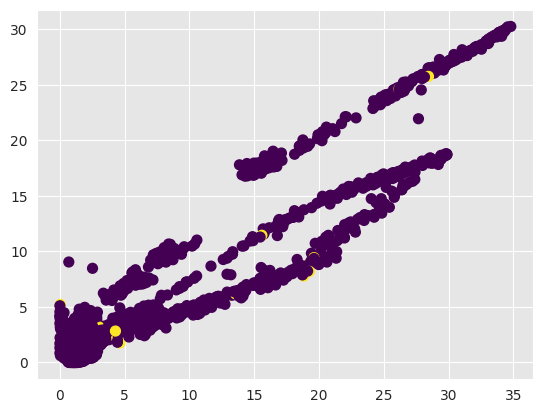

In [27]:
plt.scatter(x_train_representation[:, 0], x_train_representation[:, 1], c=y_train.numpy(), s=50, cmap='viridis')

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=SEED)
kmeans.fit(x_train_representation)
y_kmeans = kmeans.predict(x_train_representation)

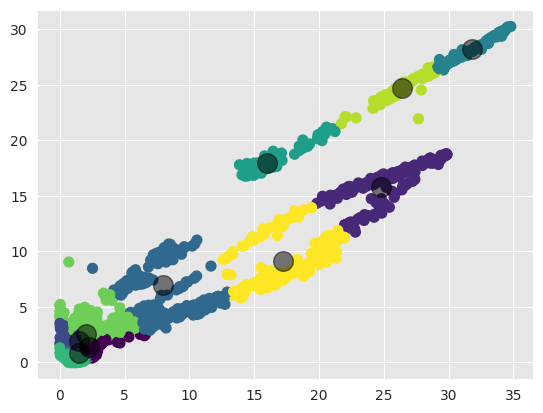

In [29]:
plt.scatter(x_train_representation[:, 0], x_train_representation[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

Detecção de fraude semi-supervisionada

In [30]:
seed_everything(SEED)

training_set_supervised = FraudDataset(x_train.to(DEVICE), y_train.to(DEVICE))
valid_set_supervised = FraudDataset(x_valid.to(DEVICE), y_valid.to(DEVICE))

training_generator_supervised,valid_generator_supervised = prepare_generators(training_set_supervised,
                                                                              valid_set_supervised,
                                                                              batch_size=64)

model_supervised = SimpleFraudMLPWithDropout(len(input_features), 1000, 0.2).to(DEVICE)
optimizer = torch.optim.Adam(model_supervised.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss().to(DEVICE)

model_supervised,training_execution_time,train_losses_dropout,valid_losses_dropout =\
    training_loop(model_supervised,
                  training_generator_supervised,
                  valid_generator_supervised,
                  optimizer,
                  criterion,
                  verbose=True)


Epoch 0: train loss: 0.10162743884112052
valid loss: 0.03573565473932712
New best score: 0.03573565473932712

Epoch 1: train loss: 0.03880523167547002
valid loss: 0.02640293455769211
New best score: 0.02640293455769211

Epoch 2: train loss: 0.031078891701333895
valid loss: 0.02378855591787463
New best score: 0.02378855591787463

Epoch 3: train loss: 0.028793505479556725
valid loss: 0.022695597669343804
New best score: 0.022695597669343804

Epoch 4: train loss: 0.02777124672747942
valid loss: 0.022126405954340605
New best score: 0.022126405954340605

Epoch 5: train loss: 0.026878768574165084
valid loss: 0.0218963841604873
New best score: 0.0218963841604873

Epoch 6: train loss: 0.026169355557145228
valid loss: 0.02173953000125297
New best score: 0.02173953000125297

Epoch 7: train loss: 0.025671396861262404
valid loss: 0.021000002198369127
New best score: 0.021000002198369127

Epoch 8: train loss: 0.024933732144559517
valid loss: 0.02112950089290901
1  iterations since best score.

Epo

In [31]:
predictions = []

for x_batch, y_batch in valid_generator_supervised: 
    predictions.append(model_supervised(x_batch.to(DEVICE)).detach().cpu().numpy())

predictions_df=valid_df
predictions_df['predictions']=np.vstack(predictions)
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.861,0.647,0.277


In [32]:
loader_params = {'batch_size': 64,
                 'num_workers': 0}
    
training_generator = torch.utils.data.DataLoader(training_set, **loader_params)
valid_generator = torch.utils.data.DataLoader(valid_set, **loader_params)

train_reconstruction = per_sample_mse(model, training_generator)
valid_reconstruction = per_sample_mse(model, valid_generator)

train_df["reconstruction_error"] = train_reconstruction
valid_df["reconstruction_error"] = valid_reconstruction

In [33]:
seed_everything(SEED)

input_features_new = input_features + ["reconstruction_error"]

# Rescale the reconstruction error
(train_df, valid_df)=scaleData(train_df, valid_df, ["reconstruction_error"])

x_train_new = torch.FloatTensor(train_df[input_features_new].values)
x_valid_new = torch.FloatTensor(valid_df[input_features_new].values)

training_set_supervised_new = FraudDataset(x_train_new.to(DEVICE), y_train.to(DEVICE))
valid_set_supervised_new = FraudDataset(x_valid_new.to(DEVICE), y_valid.to(DEVICE))

training_generator_supervised,valid_generator_supervised = prepare_generators(training_set_supervised_new,
                                                                              valid_set_supervised_new,
                                                                              batch_size=64)

model_supervised = SimpleFraudMLPWithDropout(len(input_features_new), 100, 0.2).to(DEVICE)
optimizer = torch.optim.Adam(model_supervised.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss().to(DEVICE)

model_supervised,training_execution_time,train_losses_dropout,valid_losses_dropout = \
    training_loop(model_supervised,
                  training_generator_supervised,
                  valid_generator_supervised,
                  optimizer,
                  criterion,
                  verbose=True)

predictions = []
for x_batch, y_batch in valid_generator_supervised: 
    predictions.append(model_supervised(x_batch).detach().cpu().numpy())


Epoch 0: train loss: 0.32442769453100445
valid loss: 0.11726098631411953
New best score: 0.11726098631411953

Epoch 1: train loss: 0.08669203096897436
valid loss: 0.05073176689160978
New best score: 0.05073176689160978

Epoch 2: train loss: 0.05493819376589093
valid loss: 0.03714424308918701
New best score: 0.03714424308918701

Epoch 3: train loss: 0.04567152781173387
valid loss: 0.03199159117985537
New best score: 0.03199159117985537

Epoch 4: train loss: 0.040171068735121544
valid loss: 0.02890546523960806
New best score: 0.02890546523960806

Epoch 5: train loss: 0.036413984918560884
valid loss: 0.026782149870121657
New best score: 0.026782149870121657

Epoch 6: train loss: 0.03391907549615465
valid loss: 0.02537973051295295
New best score: 0.02537973051295295

Epoch 7: train loss: 0.032187067196850466
valid loss: 0.024618811307149262
New best score: 0.024618811307149262

Epoch 8: train loss: 0.03101483122962055
valid loss: 0.023894076830010273
New best score: 0.023894076830010273



In [34]:
predictions_df=valid_df
predictions_df['predictions']=np.vstack(predictions)
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.862,0.651,0.276


Conclusão

Autoencoders fazem parte da grande família de modelos de aprendizagem profunda. Seu objetivo é aprender representações para reconstruir variáveis ​​descritivas, por isso têm sido amplamente utilizados para problemas de aprendizado não supervisionado. A detecção de anomalias e, em particular, a detecção de fraudes, pode ser abordada com técnicas não supervisionadas ou semissupervisionadas.